In [1]:
## Bibliotecas:
import pandas as pd
import numpy as np 
import seaborn as sn
import matplotlib.pyplot as plt
import graphviz 
from scipy import stats
from sklearn import metrics
from sklearn import tree 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [19]:
## Funções:

#Métricas de Avaliação:
def metricas(teste,predito):
    nome={}
    acc=metrics.accuracy_score(teste,predito)
    mcc=metrics.matthews_corrcoef(teste,predito)
    r=metrics.recall_score(teste,predito)
    p=metrics.precision_score(teste,predito)
    f1=metrics.f1_score(teste,predito)
    nome = dict(zip(['acc','mcc','r','p','f1'], [acc,mcc,r,p,f1]))
    return nome

def mc(teste,predito):
    confusion_matrix = pd.crosstab(teste, predito, rownames=['Real'], colnames=['Predito'])
    return confusion_matrix

def mapa_calor_mc(original,melhor):
    fig, (ax1, ax2) = plt.subplots(1,2)
    sn.heatmap(original, ax=ax1,annot=True)
    ax1.title.set_text('Primeiro Modelo')
    sn.heatmap(melhor, ax=ax2,annot=True)
    ax2.title.set_text('Melhor Modelo')
    fig.set_size_inches(9,3)

def shapiro_test(coluna):
    n=df.columns.get_loc(coluna)
    sp = stats.shapiro(df.iloc[:,n])
    est = sp.statistic
    pvalor = sp.pvalue
    if pvalor > 0.05:
        tipo_distribuicao='Normal'
    else:
        tipo_distribuicao='Não Normal'
    shap = dict(zip(['estatistica','pvalor','tipo_distribuicao'], [est,pvalor,tipo_distribuicao]))
    print(f'O p-valor da variável {coluna} é {pvalor:,.6f}, logo a distribuição é {tipo_distribuicao}.')
    return shap

def create_comp(original,melhor):
    data_items=original.items()
    data_list=list(data_items)
    df1=pd.DataFrame(data_list,columns=['metrica','valor'])
    data_items=melhor.items()
    data_list=list(data_items)
    df2=pd.DataFrame(data_list,columns=['metrica','valor'])
    df_comp = df1.merge(df2, how='left', on='metrica',suffixes=['_primeiro_modelo','_melhor_modelo'])
    return df_comp

In [3]:
## Variáveis Globais:

#Variáveis dos Modelos:
n_folds=30 #Número de folds
cv = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=3, random_state=1) #Geração do KFold
scoring='accuracy' #Métrica de avaliação principal

#Variáveis de ambiente (salvar figuras):
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "graficos")
os.makedirs(IMAGES_PATH, exist_ok=True)

In [4]:
## Importação do df:
df = pd.read_csv('haberman.data', header=None, names=['idade','ano','nodulos','status'])
#Ver dataframe:
print('Dados carregados:')
df.head()

Dados carregados:


,idade,ano,nodulos,status
0,30,64,1,1
1,30,62,3,1
2,30,65,0,1
3,31,59,2,1
4,31,65,4,1


Tipologia:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   idade    306 non-null    int64
 1   ano      306 non-null    int64
 2   nodulos  306 non-null    int64
 3   status   306 non-null    int64
dtypes: int64(4)
memory usage: 9.6 KB
None

Dados Gerais:
            idade         ano     nodulos      status
count  306.000000  306.000000  306.000000  306.000000
mean    52.457516   62.852941    4.026144    1.264706
std     10.803452    3.249405    7.189654    0.441899
min     30.000000   58.000000    0.000000    1.000000
25%     44.000000   60.000000    0.000000    1.000000
50%     52.000000   63.000000    1.000000    1.000000
75%     60.750000   65.750000    4.000000    2.000000
max     83.000000   69.000000   52.000000    2.000000



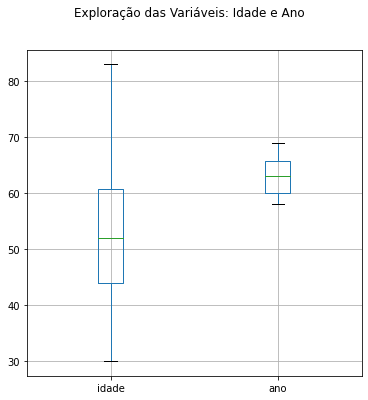

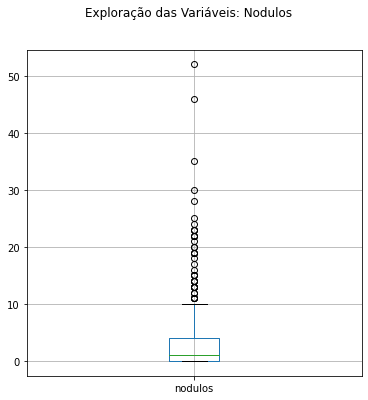

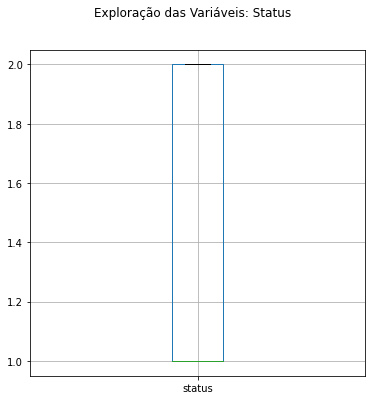

In [5]:
## Exploração do df:

#Informações:
print('Tipologia:')
info=df.info()
print(info)
print()

#Visão Geral:
resume = df.describe()
print('Dados Gerais:')
print(resume)
print()

#Comparação das Variáveis
fig = plt.figure()
fig.suptitle('Exploração das Variáveis: Idade e Ano')
fig.set_size_inches(6,6)
ax = fig.add_subplot(111)
df.boxplot(column=['idade','ano'])
plt.savefig(os.path.join(IMAGES_PATH, 'Exploracao_DF_Idade_Ano.eps'))
plt.show()
fig = plt.figure()
fig.suptitle('Exploração das Variáveis: Nodulos')
fig.set_size_inches(6,6)
ax = fig.add_subplot(111)
df.boxplot(column=['nodulos'])
plt.savefig(os.path.join(IMAGES_PATH, 'Exploracao_DF_Nodulos.eps'))
plt.show()
fig = plt.figure()
fig.suptitle('Exploração das Variáveis: Status')
fig.set_size_inches(6,6)
ax = fig.add_subplot(111)
df.boxplot(column=['status'])
plt.savefig(os.path.join(IMAGES_PATH, 'Exploracao_DF_Status.eps'))
plt.show()

In [6]:
## Teste de Shapiro:
print('Teste de Shapiro:')
shap_idade=shapiro_test('idade')
shap_nodulo=shapiro_test('nodulos')
shap_ano=shapiro_test('ano')
shap_status=shapiro_test('status')


Teste de Shapiro:
O p-valor da variável idade é 0.026047, logo a distribuição é Não Normal.
O p-valor da variável nodulos é 0.000000, logo a distribuição é Não Normal.
O p-valor da variável ano é 0.000000, logo a distribuição é Não Normal.
O p-valor da variável status é 0.000000, logo a distribuição é Não Normal.


In [7]:
## Divisão em treinamento e teste:

#Tamanho do dataframe:
print(f'Tamanho do df: {len(df):,.0f}')

#Variáveis de análise:
x=df[['idade','ano','nodulos']]

#Variável resposta:
y=df['status']

#Divisão:
np.random.seed(7)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=0)
print(f'Tamanho do treinamento: {len(x_train):,.0f}')
print(f'Tamanho do teste: {len(x_test):,.0f}')

Tamanho do df: 306
Tamanho do treinamento: 214
Tamanho do teste: 92


In [8]:
## K Folds:
# Criação dos modelos:
models = []
models.append(('Regressão Logística', LogisticRegression(solver='newton-cg')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('Árvore de Decisão', DecisionTreeClassifier()))
models.append(('Naive Bayes', GaussianNB()))
models.append(('Florestas Aleatórias', RandomForestClassifier()))
models.append(('Análise Discriminante',LinearDiscriminantAnalysis()))

# Avaliação dos modelos com os conjuntos de treino:
results = []
names = []
for name, model in models:
    cv_results = cross_val_score(model, x_train.values, y_train.values, cv=cv, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

Regressão Logística: 0.774603 (0.122613)
KNN: 0.765476 (0.127392)
Árvore de Decisão: 0.681746 (0.154500)
Naive Bayes: 0.790278 (0.123763)
Florestas Aleatórias: 0.730556 (0.144843)
Análise Discriminante: 0.785516 (0.123847)


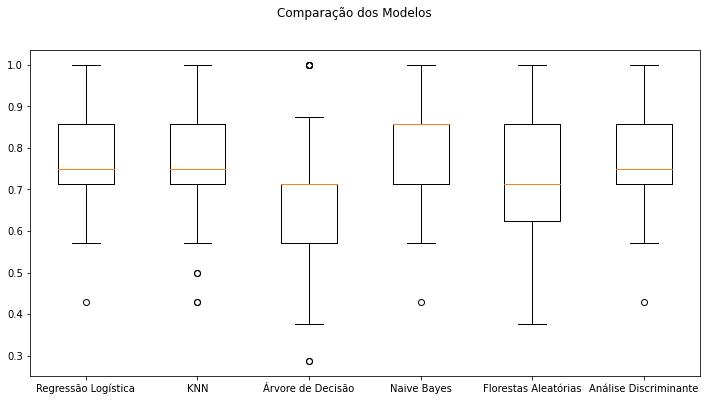

In [17]:
# Comparação dos modelos
fig = plt.figure()
fig.suptitle('Comparação dos Modelos')
fig.set_size_inches(12,6)
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.savefig(os.path.join(IMAGES_PATH, 'Comparacao_Modelos_KFold_Treinamento.eps'))
plt.show()


Matriz de Confusão:


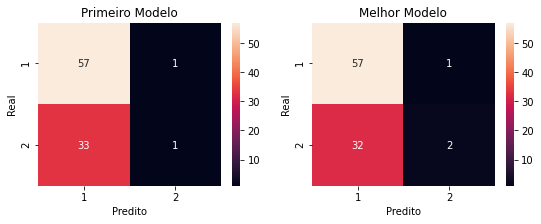


Métricas de Validação:
  metrica  valor_primeiro_modelo  valor_melhor_modelo
0     acc               0.630435             0.641304
1     mcc               0.040283             0.113007
2       r               0.982759             0.982759
3       p               0.633333             0.640449
4      f1               0.770270             0.775510


In [20]:
## Regressão Logística:

#Definição do modelo:
logistic_regression=LogisticRegression()
logistic_regression.fit(x_train,y_train)
y_pred_rl=logistic_regression.predict(x_test)

#Matriz de Confusão:
rl_mc = mc(y_test,y_pred_rl)

#Medidas de avaliação:
rl_metricas = metricas(y_test,y_pred_rl)

#Tunning do modelo:
np.random.seed(7)
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

param_grid = dict(solver=solvers,penalty=penalty,C=c_values)
grid_search = GridSearchCV(estimator=logistic_regression, param_grid=param_grid, n_jobs=-1, cv=cv, scoring=scoring,error_score=0)
grid_result = grid_search.fit(x_train, y_train)

best_solver=grid_result.best_params_['solver']
best_penalty=grid_result.best_params_['penalty']
best_C=grid_result.best_params_['C']

#Refazendo o modelo:
logistic_regression=LogisticRegression(solver=best_solver,penalty=best_penalty,C=best_C)
logistic_regression.fit(x_train.values,y_train.values)
y_pred_new_rl=logistic_regression.predict(x_test.values)

#Matriz de Confusão:
rl_new_mc = mc(y_test,y_pred_new_rl)

#Medidas de avaliação:
rl_new_metricas = metricas(y_test,y_pred_new_rl)

#Mostrar resultados:
print('Matriz de Confusão:')
mapa_calor_mc(rl_mc,rl_new_mc)
plt.savefig(os.path.join(IMAGES_PATH, 'RL_Matriz_Confusao.eps'))
plt.show()
print()
print('Métricas de Validação:')
df_rl=create_comp(rl_metricas,rl_new_metricas)
print(df_rl)


Matriz de Confusão:


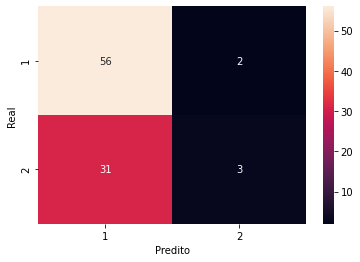


Métricas de Validação:
  metrica  valor_melhor_modelo
0     acc             0.641304
1     mcc             0.114448
2       r             0.965517
3       p             0.643678
4      f1             0.772414


In [21]:
## Análise Discriminante:

#Definição do modelo:
discriminant_analysis=LinearDiscriminantAnalysis()
discriminant_analysis.fit(x_train,y_train)
y_pred_da=discriminant_analysis.predict(x_test)

#Matriz de Confusão:
ad_mc = mc(y_test,y_pred_da)

#Medidas de avaliação:
ad_metricas = metricas(y_test,y_pred_da)

#Mostrar resultados:
print('Matriz de Confusão:')
sn.heatmap(ad_mc,annot=True)
plt.savefig(os.path.join(IMAGES_PATH, 'AD_Matriz_Confusao.eps'))
plt.show()
print()
print('Métricas de Validação:')
data_items=ad_metricas.items()
data_list=list(data_items)
df_ad=pd.DataFrame(data_list,columns=['metrica','valor_melhor_modelo'])
print(df_ad)


Matriz de Confusão:


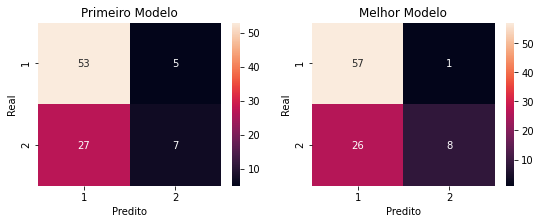


Métricas de Validação:
  metrica  valor_primeiro_modelo  valor_melhor_modelo
0     acc               0.652174             0.706522
1     mcc               0.171523             0.354287
2       r               0.913793             0.982759
3       p               0.662500             0.686747
4      f1               0.768116             0.808511


In [22]:
## KNN:

#Definição do modelo:
knn=KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train.values,y_train.values)
y_pred_knn=knn.predict(x_test.values)

#Matriz de Confusão:
knn_mc = mc(y_test,y_pred_knn)

#Medidas de avaliação:
knn_metricas = metricas(y_test,y_pred_knn)

#Definir melhor k:
np.random.seed(7)

k = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]
distancias = ['euclidean', 'manhattan', 'minkowski']

param_grid = dict(n_neighbors=k, metric=distancias)
grid = GridSearchCV(estimator=knn, param_grid=param_grid, scoring=scoring, cv=cv)
grid_result = grid.fit(x_train.values, y_train.values)
best_k=grid_result.best_params_['n_neighbors']
best_acc=grid_result.best_score_
best_dist=grid_result.best_params_['metric']

#Refazendo o modelo:
knn=KNeighborsClassifier(n_neighbors=best_k,metric=best_dist)
knn.fit(x_train.values,y_train.values)
y_pred_knn=knn.predict(x_test.values)

#Matriz de Confusão:
knn_new_mc = mc(y_test,y_pred_knn)

#Medidas de avaliação:
knn_new_metricas = metricas(y_test,y_pred_knn)

#Mostrar resultados:
print('Matriz de Confusão:')
mapa_calor_mc(knn_mc,knn_new_mc)
plt.savefig(os.path.join(IMAGES_PATH, 'KNN_Matriz_Confusao.eps'))
plt.show()
print()
print('Métricas de Validação:')
df_knn=create_comp(knn_metricas,knn_new_metricas)
print(df_knn)

Fitting 30 folds for each of 50 candidates, totalling 1500 fits
Árvore de Decisão do Melhor Modelo:


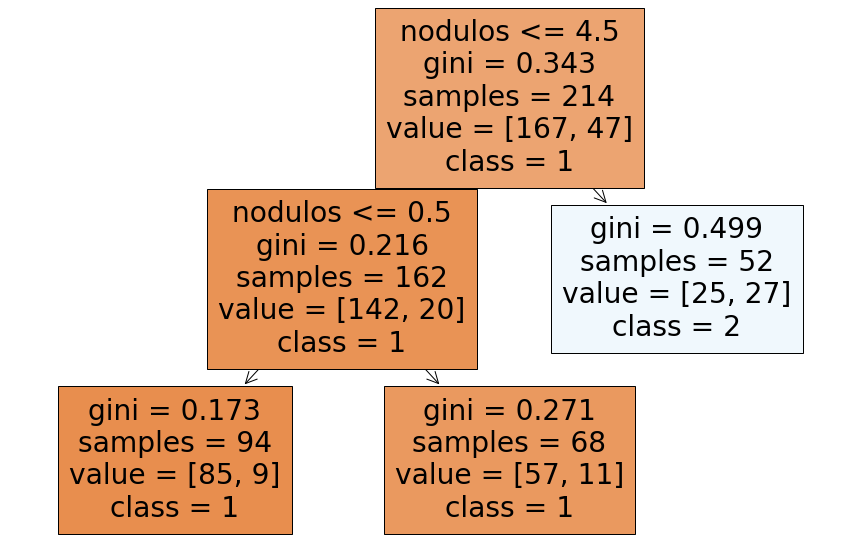

Matriz de Confusão:


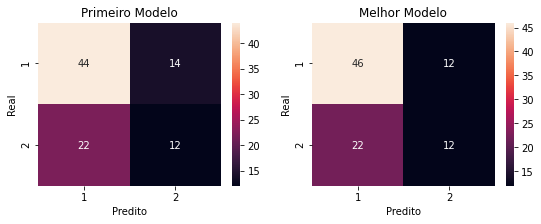


Métricas de Validação:
  metrica  valor_primeiro_modelo  valor_melhor_modelo
0     acc               0.608696             0.630435
1     mcc               0.119594             0.160538
2       r               0.758621             0.793103
3       p               0.666667             0.676471
4      f1               0.709677             0.730159


In [23]:
## Árvore de Decisão: 

#Definição do modelo:
arv_dec=DecisionTreeClassifier()
arv_dec.fit(x_train.values,y_train.values)
y_pred_arv_dec=arv_dec.predict(x_test.values)

#Matriz de Confusão:
arv_dec_mc = mc(y_test,y_pred_arv_dec)

#Medidas de avaliação:
arv_dec_metricas = metricas(y_test,y_pred_arv_dec)

#Tunning o modelo:
np.random.seed(7)

max_depth = [2, 3, 5, 10, 20]
min_samples_leaf = [5, 10, 20, 50, 100]
criterion = ["gini", "entropy"]

param_grid = dict(max_depth=max_depth, min_samples_leaf=min_samples_leaf,criterion=criterion)

grid_search = GridSearchCV(estimator=arv_dec, param_grid=param_grid, cv=n_folds, n_jobs=-1, verbose=1, scoring = "accuracy")
grid_result=grid_search.fit(x_train, y_train)
prof=grid_result.best_params_['max_depth']
minimo=grid_result.best_params_['min_samples_leaf']
crit=grid_result.best_params_['criterion']

#Refazendo modelo:
arv_dec=DecisionTreeClassifier(max_depth=prof, min_samples_leaf=minimo,criterion=crit)
arv_dec.fit(x_train.values,y_train.values)
y_pred_arv_dec_new=arv_dec.predict(x_test.values)

#Mostrar a árvore:
print('Árvore de Decisão do Melhor Modelo:')
fig = plt.figure(figsize=(15,10))
_ = tree.plot_tree(arv_dec, feature_names=x.columns,filled=True,class_names=['1','2'])
plt.savefig(os.path.join(IMAGES_PATH, 'Arvore_decisao.eps'))
plt.show()

#Matriz de Confusão:
arv_dec_new_mc = mc(y_test,y_pred_arv_dec_new)

#Medidas de avaliação:
arv_dec_new_metricas = metricas(y_test,y_pred_arv_dec_new)

#Mostrar resultados:
print('Matriz de Confusão:')
mapa_calor_mc(arv_dec_mc,arv_dec_new_mc)
plt.savefig(os.path.join(IMAGES_PATH, 'Arvore_Decisao_Matriz_Confusao.eps'))
plt.show()
print()
print('Métricas de Validação:')
df_arv_dec=create_comp(arv_dec_metricas,arv_dec_new_metricas)
print(df_arv_dec)

Fitting 90 folds for each of 300 candidates, totalling 27000 fits
Matriz de Confusão:


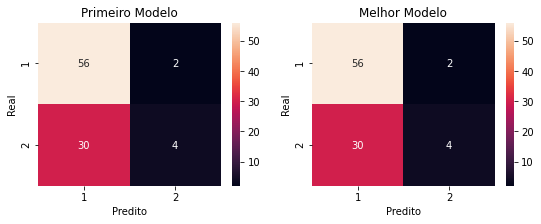


Métricas de Validação:
  metrica  valor_primeiro_modelo  valor_melhor_modelo
0     acc               0.652174             0.652174
1     mcc               0.162579             0.162579
2       r               0.965517             0.965517
3       p               0.651163             0.651163
4      f1               0.777778             0.777778


In [28]:
## Naive Bayes: 

#Definição do modelo:
NB=GaussianNB()
NB.fit(x_train.values,y_train.values)
y_pred_NB=NB.predict(x_test.values)

#Matriz de Confusão:
NB_mc = mc(y_test,y_pred_NB)

#Medidas de avaliação:
NB_metricas = metricas(y_test,y_pred_NB)

#Tunning o modelo:
np.random.seed(7)

var_smoothing = np.logspace(0,-9, num=100)
param_grid = dict(var_smoothing=var_smoothing)

grid_search = GridSearchCV(estimator=NB, param_grid=param_grid, cv=cv, n_jobs=-1, verbose=1, scoring=scoring)
grid_result=grid_search.fit(x_train, y_train)
var=grid_result.best_params_['var_smoothing']

#Refazendo modelo:
NB=GaussianNB(var_smoothing=var)
NB.fit(x_train.values,y_train.values)
y_pred_new_NB=NB.predict(x_test.values)

#Matriz de Confusão:
NB_new_mc = mc(y_test,y_pred_new_NB)

#Medidas de avaliação:
NB_new_metricas = metricas(y_test,y_pred_new_NB)

#Mostrar resultados:
print('Matriz de Confusão:')
mapa_calor_mc(NB_mc,NB_new_mc)
plt.savefig(os.path.join(IMAGES_PATH, 'NB_Matriz_Confusao.eps'))
plt.show()
print()
print('Métricas de Validação:')
df_NB=create_comp(NB_metricas,NB_new_metricas)
print(df_NB)

Fitting 90 folds for each of 12 candidates, totalling 1080 fits
Matriz de Confusão:


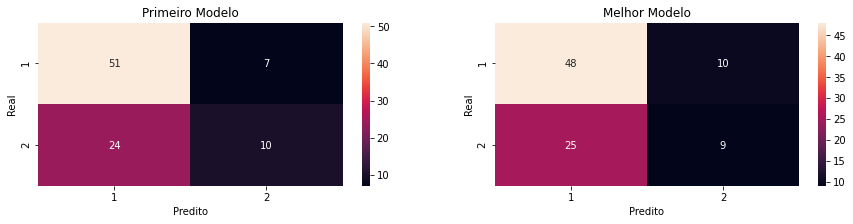


Métricas de Validação:
  metrica  valor_primeiro_modelo  valor_melhor_modelo
0     acc               0.663043             0.619565
1     mcc               0.215684             0.110047
2       r               0.879310             0.827586
3       p               0.680000             0.657534
4      f1               0.766917             0.732824


In [15]:
## Floresta Aleatória:

#Definição do modelo:
rf=RandomForestClassifier()
rf.fit(x_train.values,y_train.values)
y_pred_rf=rf.predict(x_test.values)

#Matriz de Confusão:
rf_mc = mc(y_test,y_pred_rf)

#Medidas de avaliação:
rf_metricas = metricas(y_test,y_pred_rf)

#Tunning o modelo:
np.random.seed(7)

n_estimators = [10,20,50,100,200,500]
max_features = ['sqrt', 'log2']
param_grid = dict(n_estimators=n_estimators,max_features=max_features)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=cv, n_jobs=-1, verbose=1, scoring=scoring)
grid_result=grid_search.fit(x_train, y_train)
n_estimators=grid_result.best_params_['n_estimators']
max_features=grid_result.best_params_['max_features']

#Refazendo modelo:
rf=RandomForestClassifier(n_estimators=n_estimators,max_features=max_features)
rf.fit(x_train.values,y_train.values)
y_pred_new_rf=rf.predict(x_test.values)

#Matriz de Confusão:
rf_new_mc = mc(y_test,y_pred_new_rf)

#Medidas de avaliação:
rf_new_metricas = metricas(y_test,y_pred_new_rf)

#Mostrar resultados:
print('Matriz de Confusão:')
mapa_calor_mc(rf_mc,rf_new_mc)
plt.savefig(os.path.join(IMAGES_PATH, 'Floresta_Aleatoria_Matriz_Confusao.png'))
plt.show()
print()
print('Métricas de Validação:')
df_rf=create_comp(rf_metricas,rf_new_metricas)
print(df_rf)

In [16]:
## Comparação de resultados

#Criação de coluna de método:
df_rl['metodo']='regressao logistica'
df_ad['metodo']='analise discriminante'
df_knn['metodo']='knn'
df_NB['metodo']='naive bayes'
df_arv_dec['metodo']='arvore decisao'
df_rf['metodo']='florestas aleatorias'

#DataFrame de análise:
df_analise=[]
frames=[df_rl[['metrica','valor_melhor_modelo','metodo']],df_ad[['metrica','valor_melhor_modelo','metodo']],df_knn[['metrica','valor_melhor_modelo','metodo']],df_NB[['metrica','valor_melhor_modelo','metodo']],df_arv_dec[['metrica','valor_melhor_modelo','metodo']],df_rf[['metrica','valor_melhor_modelo','metodo']]]
df_analise=pd.concat(frames)

#Ver método com melhores métricas:
idx = df_analise.groupby(['metrica'])['valor_melhor_modelo'].transform(max) == df_analise['valor_melhor_modelo']
df_result=df_analise[idx]
df_result.sort_values(by='metrica')

,metrica,valor_melhor_modelo,metodo
0,acc,0.706522,knn
4,f1,0.808511,knn
1,mcc,0.354287,knn
3,p,0.686747,knn
2,r,0.982759,regressao logistica
2,r,0.982759,knn


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


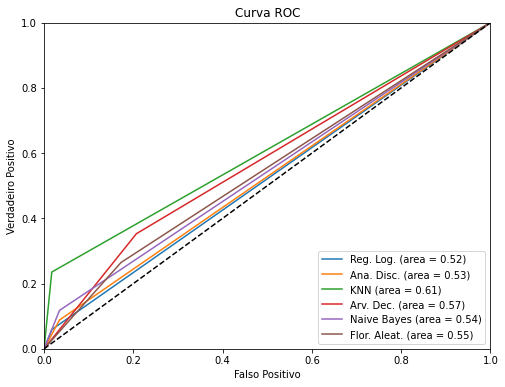

In [51]:
## Curva ROC:

fpr_rl, tpr_rl, threshold = metrics.roc_curve(y_test, y_pred_new_rl,pos_label=2)
roc_rl = metrics.auc(fpr_rl,tpr_rl)
fpr_da, tpr_da, threshold = metrics.roc_curve(y_test, y_pred_da,pos_label=2)
roc_da = metrics.auc(fpr_da,tpr_da)
fpr_knn, tpr_knn, threshold = metrics.roc_curve(y_test, y_pred_knn,pos_label=2)
roc_knn = metrics.auc(fpr_knn,tpr_knn)
fpr_arv_dec, tpr_arv_dec, threshold = metrics.roc_curve(y_test, y_pred_arv_dec_new,pos_label=2)
roc_arv_dec = metrics.auc(fpr_arv_dec,tpr_arv_dec)
fpr_nb, tpr_nb, threshold = metrics.roc_curve(y_test, y_pred_new_NB,pos_label=2)
roc_nb = metrics.auc(fpr_nb,tpr_nb)
fpr_rf, tpr_rf, threshold = metrics.roc_curve(y_test, y_pred_new_rf,pos_label=2)
roc_rf = metrics.auc(fpr_rf,tpr_rf)
fig = plt.figure()
fig.set_size_inches(8,6)
plt.plot(fpr_rl, tpr_rl, label='Reg. Log. (area = %0.2f)' % roc_rl)
plt.plot(fpr_da, tpr_da, label='Ana. Disc. (area = %0.2f)' % roc_da)
plt.plot(fpr_knn, tpr_knn, label='KNN (area = %0.2f)' % roc_knn)
plt.plot(fpr_arv_dec, tpr_arv_dec, label='Arv. Dec. (area = %0.2f)' % roc_arv_dec)
plt.plot(fpr_nb, tpr_nb, label='Naive Bayes (area = %0.2f)' % roc_nb)
plt.plot(fpr_rf, tpr_rf, label='Flor. Aleat. (area = %0.2f)' % roc_rf)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadeiro Positivo')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.savefig(os.path.join(IMAGES_PATH, 'Curva_ROC.eps'))
plt.show()